Hands-On Lecture 9

We start by loading the data into dataframes.

In [85]:
# Import the necessary packages
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
# import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor

###  Load prosumer data ###
file_P = os.path.join(os.getcwd(),'ProsumerHourly_withUTC - Copy.csv')
df_pro = pd.read_csv(file_P)
df_pro["TimeUTC"] = pd.to_datetime(df_pro["TimeUTC"])
df_pro = df_pro.loc[df_pro["TimeUTC"].dt.year.isin([2022,2023])]
df_pro = df_pro.reset_index(drop=True)
df_pro.rename(columns={'Consumption': 'Load'}, inplace=True)
df_pro.rename(columns={'TimeUTC': 'HourUTC'}, inplace=True)
df_pro = df_pro[["HourUTC","Load","PV"]]
    
###  Load weather data ###
file_P = os.path.join(os.getcwd(),'WeatherData - Copy.csv')
df_weather = pd.read_csv(file_P)
df_weather["HourUTC"] = pd.to_datetime(df_weather["HourUTC"])
df_weather = df_weather.loc[df_weather["HourUTC"].dt.year.isin([2022,2023])]
df_weather = df_weather.drop(df_weather.index[-1])

### Merge the dataframes ###
df_merged = pd.merge(df_pro, df_weather, on='HourUTC')
df_merged = df_merged.drop(['index'], axis=1)

df_merged.rename(columns={'snow_soiling_rooftop': 'snow', 
                          'clearsky_dhi': 'cs_dhi', 
                          'clearsky_dni': 'cs_dni',
                          'clearsky_ghi': 'cs_ghi', 
                          'clearsky_gti': 'cs_gti',
                          'cloud_opacity': 'opacity',
                          'dewpoint_temp': 'dew_t'}, inplace=True)

Here, we plot the data for a time-specific period

In [2]:
# Define the period on which you want to build your LSTM model
t_s = pd.Timestamp(dt.datetime(, , , , , ))
t_e = pd.Timestamp(dt.datetime(, , , , , ))

data = df_merged.loc[(df_merged['HourUTC']>=t_s) & (df_merged['HourUTC']<=t_e)]
data = data.reset_index(drop=True)

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(data['Load'])
plt.title('Consumption')
plt.xlabel('Hour')
plt.ylabel('Consumption (kW)')

SyntaxError: invalid syntax (3724373603.py, line 2)

Predict the consumption 1 hour ahead

Split the dataset in a training, validation and test data set

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
data_scaled = sc.fit_transform(data['Load'].values.reshape(-1,1))
look_back =  # Number of previous time steps to use as input features
look_ahead = # Number of time steps to look ahead

training_rate = 
split_index = int((len(data)-look_back-look_ahead)*training_rate)
validation_rate = 
split_val_index = int((training_rate+validation_rate)*(len(data)-look_ahead-look_back))
testing_rate = 

from keras.models import Sequential
from keras.layers import LSTM, Dense
# Prepare data for LSTM

# Prepare training data
X_train, y_train = [], []
for i in range(look_back+look_ahead, split_index):
    X_train.append(data_scaled[i-look_ahead-look_back:i-look_ahead, 0])
    y_train.append(data_scaled[i-look_ahead:i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_val, y_val = [], []
# Prepare validation data
for i in range(split_index+look_ahead, split_val_index):
    X_val.append(data_scaled[i - look_ahead - look_back:i - look_ahead, 0])
    y_val.append(data_scaled[i - look_ahead:i, 0])
X_val, y_val =  np.array(X_val), np.array(y_val)

# Predict on the remaining data
X_test, y_test = [], []
for i in range(split_val_index+look_ahead, len(data_scaled)+look_ahead):
    X_test.append(data_scaled[i-look_ahead-look_back:i-look_ahead, 0])
    y_test.append(data_scaled[i-look_ahead:i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

n_train = len(X_train)
n_val = len(X_val)
n_test = len(X_test)
n_data = len(data)

print(f'Size training data: {n_train}, Size validation set: {n_val}, Size testing data: {n_test}, Size data: {n_data}')

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(np.arange(look_back+look_ahead,n_train+look_back+look_ahead), y_train)
plt.plot(np.arange(n_train+look_ahead+look_back, n_train+n_val+look_back+look_ahead), y_val)
plt.plot(np.arange(n_train+n_val+look_ahead+look_back, n_data-look_ahead), y_test)
plt.legend(["Training set", "Validation set", "Testing set"])
plt.grid(alpha=0.25)
plt.ylabel("Consumption (kW)")
plt.xlabel("Hour")
plt.tight_layout()

Build the LSTM model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


# Reshape input data for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=, batch_size=, validation_data=(X_val, y_val))

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_pred = model.predict(X_test)

Plot the predicted consumption vs the actual consumption.

ValueError: x and y must have same first dimension, but have shapes (618,) and (386, 1)

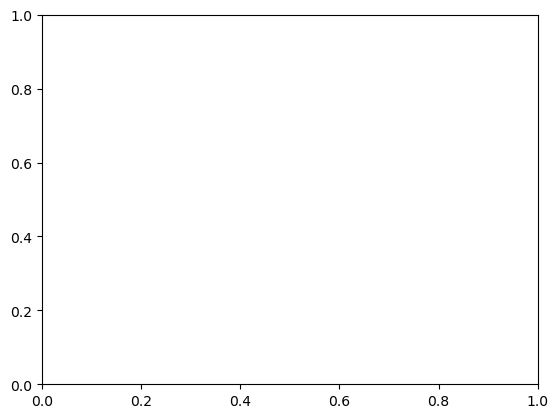

In [87]:
predicted_consumption = sc.inverse_transform(y_pred)
plt.plot(np.arange(n_train+n_val+look_back+look_ahead, n_data-look_ahead), predicted_consumption, label='Predicted Consumption')
plt.plot(data['Load'][n_train+n_val+look_ahead+look_back:n_data-look_ahead], label='Actual Consumption')
# plt.plot(data['Load'][:n_train+n_val+look_ahead+look_back], label = 'Historical consumption')
plt.xlabel('Hour')
plt.ylabel('Consumption (kW)')
plt.legend()

Plot your training and validation loss

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Evaluate your model using the following metrics:

In [ ]:
## Metrics to evaluate the performance of your model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import load_model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)


Train a new model using dropout and the ReLU activation function. 

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.activations import relu

dropout = 

# Reshape input data for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation=, recurrent_dropout=dropout, dropout=dropout))
model.add(Dropout(dropout))

model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=, batch_size=, validation_data=(X_val, y_val))

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_pred = model.predict(X_test)

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## Metrics to evaluate the performance of your model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import load_model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)


Now, predict the consumption 12 hours ahead

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
data_scaled = sc.fit_transform(data['Load'].values.reshape(-1,1))
split_index = int(len(data)*0.8)

from keras.models import Sequential
from keras.layers import LSTM, Dense
# Prepare data for LSTM
look_back =  # Number of previous time steps to use as input features
look_ahead = 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
data_scaled = sc.fit_transform(data['Load'].values.reshape(-1,1))
look_back =  # Number of previous time steps to use as input features
look_ahead = # Number of time steps to look ahead


# Define the ratios for training, validation and testing sets
training_rate = 
validation_rate = 
testing_rate =


split_index = int((len(data)-look_back-look_ahead)*training_rate)
split_val_index = int((training_rate+validation_rate)*(len(data)-look_ahead-look_back))


from keras.models import Sequential
from keras.layers import LSTM, Dense

# Prepare data for LSTM
# Prepare training data
X_train, y_train = [], []
for i in range(look_back+look_ahead, split_index-look_ahead):
    X_train.append(data_scaled[i-look_ahead-look_back:i-look_ahead, 0])
    y_train.append(data_scaled[i-look_ahead:i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_val, y_val = [], []
# Prepare validation data
for i in range(split_index-look_ahead+1, split_val_index-look_ahead):
    X_val.append(data_scaled[i - look_ahead - look_back:i - look_ahead, 0])
    y_val.append(data_scaled[i - look_ahead:i, 0])
X_val, y_val =  np.array(X_val), np.array(y_val)

# Predict on the remaining data
X_test, y_test = [], []
for i in range(split_val_index-look_ahead+1, len(data_scaled)-look_ahead):
    X_test.append(data_scaled[i-look_ahead-look_back:i-look_ahead, 0])
    y_test.append(data_scaled[i-look_ahead:i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

n_train = len(X_train)
n_val = len(X_val)
n_test = len(X_test)
n_data = len(data)

print(f'Size training data: {n_train}, Size validation set: {n_val}, Size testing data: {n_test}, Size data: {n_data}')


plt.figure(figsize=(6, 4), dpi=100)
plt.plot(np.arange(look_back,look_back+look_ahead), y_train[0])
plt.plot(np.arange(0, look_back), X_train[0])
plt.plot(np.arange(split_index, split_index+look_back), X_val[0])
plt.plot(np.arange(split_index+look_back, split_index+look_back+look_ahead), y_val[0])
plt.plot(np.arange(split_val_index, split_val_index+look_back), X_test[0])
plt.plot(np.arange(split_val_index+look_back, split_val_index+look_back+look_ahead), y_test[0])
plt.legend(["Training set, y", "Training set, X", "Validation set, X", "Validation set, y","Testing set, X", "Testing set, y"])
plt.grid(alpha=0.25)
plt.ylabel("Consumption (kW)")
plt.tight_layout()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
data_scaled = sc.fit_transform(data['Load'].values.reshape(-1,1))
look_back =  # Number of previous time steps to use as input features
look_ahead = 

training_rate = 
split_index = int((len(data))*training_rate)
validation_rate = 
split_val_index = int((training_rate+validation_rate)*(len(data)))
testing_rate = 

from keras.models import Sequential
from keras.layers import LSTM, Dense

X_train, y_train = [], []
for i in range(look_back+look_ahead, split_index):
    X_train.append(data_scaled[i-look_ahead-look_back:i-look_ahead, 0])
    y_train.append(data_scaled[i-look_ahead:i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_val, y_val = [], []
# Prepare validation data
for i in range(split_index+look_ahead, split_val_index):
    X_val.append(data_scaled[i - look_ahead - look_back:i - look_ahead, 0])
    y_val.append(data_scaled[i - look_ahead:i, 0])
X_val, y_val =  np.array(X_val), np.array(y_val)

# Predict on the remaining data
X_test, y_test = [], []
for i in range(split_val_index+look_ahead, len(data_scaled)):
    X_test.append(data_scaled[i-look_ahead-look_back:i-look_ahead, 0])
    y_test.append(data_scaled[i-look_ahead:i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)


n_train = len(X_train)
n_val = len(X_val)
n_test = len(X_test)
n_data = len(data)

print(f'Size training data: {n_train}, Size validation set: {n_val}, Size testing data: {n_test}, Size data: {n_data}')


plt.figure(figsize=(6, 4), dpi=100)
plt.plot(np.arange(look_back,look_back+look_ahead), y_train[0])
plt.plot(np.arange(0, look_back), X_train[0])
plt.plot(np.arange(split_index, split_index+look_back), X_val[0])
plt.plot(np.arange(split_index+look_back, split_index+look_back+look_ahead), y_val[0])
plt.plot(np.arange(split_val_index, split_val_index+look_back), X_test[0])
plt.plot(np.arange(split_val_index+look_back, split_val_index+look_back+look_ahead), y_test[0])
plt.legend(["Training set, y", "Training set, X", "Validation set, X", "Validation set, y","Testing set, X", "Testing set, y"])
plt.grid(alpha=0.25)
plt.ylabel("Consumption (kW)")
plt.xlabel('Hour')
plt.tight_layout()

In [57]:
## Metrics to evaluate the performance of your model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import load_model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)


Mean Squared Error (MSE): 0.01186806820891568
Mean Absolute Error (MAE): 0.05465132788918211
Root Mean Squared Error (RMSE): 0.10894066370697253
R-squared (R2) Score: 0.17036669793231274


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed


# Reshape input data for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# # model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=look_ahead))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_pred = model.predict(X_test)

Predict the PV consumption, implement your own model.

In [ ]:
t_s =
t_e = 

data = df_merged.loc[(df_merged['HourUTC']>=t_s) & (df_merged['HourUTC']<=t_e)]
data = data.reset_index(drop=True)

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(data['PV'])
plt.title('PV Production')
plt.xlabel('Hour')
plt.ylabel('PV Production (kW)')

In [3]:
### Train here your own model. Plot the predicted production

Plot the correlation matrix

In [ ]:
import seaborn as sns
data_corr = data.drop(['HourUTC', 'Load'], axis=1)
correlation_matrix = data_corr.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

print(correlation_matrix['PV'])

Add exogenous variables

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
exog = ['PV', .., ... ] # Fill in the columns that you want to train the model on
target = []
data_scaled = sc.fit_transform(data[exog])
target_scaled = sc.fit_transform(data[target])
look_back =  # Number of previous time steps to use as input features
look_ahead = 

training_rate = 
split_index = int((len(data)-look_back-look_ahead)*training_rate)
validation_rate = 
split_val_index = int((training_rate+validation_rate)*(len(data)-look_ahead-look_back))
testing_rate = 

from keras.models import Sequential
from keras.layers import LSTM, Dense


# Prepare training data
X_train, y_train = [], []
for i in range(look_back+look_ahead, split_index):
    X_train.append(data_scaled[i-look_ahead-look_back:i-look_ahead, :])
    y_train.append(data_scaled[i-look_ahead:i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_val, y_val = [], []
# Prepare validation data
for i in range(split_index+look_ahead, split_val_index):
    X_val.append(data_scaled[i - look_ahead - look_back:i - look_ahead, :])
    y_val.append(data_scaled[i - look_ahead:i, 0])
X_val, y_val =  np.array(X_val), np.array(y_val)

# Predict on the remaining data
X_test, y_test = [], []
for i in range(split_val_index+look_ahead, len(data)+look_ahead):
    X_test.append(data_scaled[i-look_ahead-look_back:i-look_ahead, :])
    y_test.append(data_scaled[i-look_ahead:i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

n_train = len(y_train)
n_val = len(y_val)
n_test = len(y_test)
n_data = len(data)

print(f'Size training data: {n_train}, Size validation set: {n_val}, Size testing data: {n_test}, Size data: {n_data}')


# Reshape input data for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],len(exog)))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], len(exog)))



In [ ]:
## Train here your own model. Use metrics to evaluate the performance

In [ ]:
predicted_production = sc.inverse_transform(y_pred)
plt.plot(np.arange(n_train+n_val+look_back+look_ahead, n_data-look_ahead), predicted_consumption, label='Predicted production')
plt.plot(data['PV'][n_train+n_val+look_ahead+look_back:n_data-look_ahead], label='Actual production')
plt.plot(data['PV'][:n_train+n_val+look_ahead+look_back], label = 'Historical production')
plt.xlabel('Hour')
plt.ylabel('Production (kW)')
plt.legend()